In [1]:
# IMPORT STATEMENTS

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#Machine Learning package
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
print(tf.__version__)

#Interpreting neural networks 
import  shap


import os
import re

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Instructions for updating:
non-resource variables are not supported in the long term
2.20.0


## Path & Files

In [2]:
BASE_PATH = "/Users/hayeonchung/Downloads/Mamalakis Graduate Research/"

FILES = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree (1).nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree (1).nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree (1).nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree (1).nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree (1).nc",
]
FILES = [os.path.join(BASE_PATH, f) for f in FILES]

## Variable Index Map and Units

In [3]:
# Variable order is explicitly given by metadata:
# "tas, tasmax, tasmin, pr, psl, sfcWind, mrsos"
VAR_TO_INDEX = {
    "tas": 0,
    "tasmax": 1,
    "tasmin": 2,
    "pr": 3,
    "psl": 4,
    "sfcWind": 5,
    "mrsos": 6,
}

# Units are also given:
VAR_UNITS = {
    "tas": "K",
    "tasmax": "K",
    "tasmin": "K",
    "pr": "kg/m2s",
    "psl": "Pa",
    "sfcWind": "m/s",
    "mrsos": "kg/m2",
}

## Time Handling (Monthly Index → Years)

In [4]:
def get_model_name(path: str) -> str:
    # Everything before "_ssp..."
    return os.path.basename(path).split("_ssp")[0]


def months_to_year_month(time_months: np.ndarray, start_year=2015, start_month=1):
    """
    File says time units are 'months' and it spans 2015-2100.
    This creates year + month arrays assuming the first index corresponds to Jan 2015.

    If my time axis is "month count since 2015-01", this is correct.
    If not, it still gives consistent indexing as long as the file starts at 2015-01.
    """
    # time_months is usually 0..1031 or 1..1032 depending on how the file was written but I handle either by shifting to 0-based.
    t = np.array(time_months, dtype=int)
    if t.min() == 1:
        t = t - 1

    # compute year/month
    year = start_year + (start_month - 1 + t) // 12  
    month = (start_month - 1 + t) % 12 + 1 # check why it's plus one 
    return year, month


def time_mask_for_year_range(ds: nc.Dataset, start_year: int, end_year: int):
    """
    Create a mask over the monthly time axis using year bounds.
    """
    t = ds["time"][:]
    year, month = months_to_year_month(t, start_year=2015, start_month=1)
    return (year >= start_year) & (year <= end_year)

## Unit Conversions and Standardization

In [5]:
def convert_units(varname: str, x: np.ndarray) -> tuple[np.ndarray, str]:
    """
    Convert raw units into nicer plotting/interpretation units.
    - tas/tasmax/tasmin: K to C
    - pr: kg/m2s to mm/day  (1 kg/m2 = 1 mm water; multiply by 86400)
    - psl: Pa to hPa
    - sfcWind: keep m/s
    - mrsos: keep kg/m2 
    """
    if varname in {"tas", "tasmax", "tasmin"}:
        return x - 273.15, "°C"
    if varname == "pr":
        return x * 86400.0, "mm/day"
    if varname == "psl":
        return x / 100.0, "hPa"
    if varname == "sfcWind":
        return x, "m/s"
    if varname == "mrsos":
        return x, "kg/m²"
    return x, "unknown"

## Statistics Functions (Mean, Std, Median, Percentiles)

In [6]:
def compute_stat_over_time(x: np.ndarray, stat: str) -> np.ndarray:
    """
    x: (ens, time, lat, lon) after loading and swapping
    Returns: (ens, lat, lon) after aggregating over time
    Supported stats:
      - mean (default)
      - std
      - median
      - percentile_XX  (ex. percentile_95)
    """
    s = stat.lower().strip()

    if s == "mean":
        return np.nanmean(x, axis=1) # axis=1 refers to the time dimension, np.namean ignores the missing values
    if s == "std":
        return np.nanstd(x, axis=1)
    if s == "median":
        return np.nanmedian(x, axis=1)

    m = re.match(r"percentile[_\s-]?(\d+)", s) # re.match matches the pattern at the beginning of the string and [] matches any character inside the brackets
    if m: # true only if user asked for a percentile value
        p = float(m.group(1)) # extract the percentile value from the matched pattern
        return np.nanpercentile(x, p, axis=1) # compute the percentile over time 

    raise ValueError(f"Unknown stat '{stat}'. Use mean/std/median/percentile_XX.")

## Loading and Aggregating Data for One Model

### Essentially what this does: From one climate model file, extract one variable, for one scenario, over a specific time window, and return a single spatial map that represents a statistic (mean, max, etc.) averaged across ensembles

In [7]:
def load_model_period_map(
    file_path: str,
    scenario: str,
    varname: str,
    start_year: int,
    end_year: int,
    stat: str = "mean",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, str]:
    """
    Load a model, select scenario & variable, subset time range, compute stat map.
    Returns:
      lat (lat,), lon (lon,), map (lat, lon), unit_label
    """
    scenario = scenario.lower()
    if scenario not in {"ssp119", "ssp126"}:
        raise ValueError("scenario must be 'ssp119' or 'ssp126'")

    key = f"data_{scenario}"
    vidx = VAR_TO_INDEX[varname]

    ds = nc.Dataset(file_path)

    lat = np.array(ds["lat"][:]) # extracting latitude and longitude grids
    lon = np.array(ds["lon"][:])

    # time subset (monthly)
    mask = time_mask_for_year_range(ds, start_year, end_year) # creating a boolean mask that selects only the months between start_year and end_year
    if mask.sum() == 0:
        ds.close()
        raise ValueError(f"No months found between {start_year}-{end_year} in {file_path}")

    # raw shape: (ens, var, time, lon, lat)
    raw = ds[key]

    x = np.array(raw[:, vidx, mask, :, :], dtype=float)  # slicing the 5D array into (ens, time, lon, lat) by selecting scenario (key), variable (vidx), and time (mask)
    ds.close()

    # swap to (ens, time, lat, lon) from (ens, time, lon, lat) 
    x = x.swapaxes(-1, -2)

    # unit conversion
    x, unit_label = convert_units(varname, x)

    # compute stat over time -> (ens, lat, lon) using the specified statistic to translate temporal information into climate signal by summarizing climate behavior over a definied period
    ens_maps = compute_stat_over_time(x, stat)

    # average across ensembles -> (lat, lon) by taking the mean of the ensembles
    out_map = np.nanmean(ens_maps, axis=0)

    return lat, lon, out_map, unit_label

## Plotting Global Map

### Essentially what this does: It takes a 2D global field (latitude × longitude) and produces a global map using a cartographic projection. By the time this function is called, all processing (model selection, unit conversion, temporal aggregation, ensemble averaging) is already done. This function is purely about visualizing the final result correctly and clearly.

In [8]:
def plot_global_map(
    lat,
    lon,
    field_latlon,
    title,
    unit_label="",
    symmetric=False,
    vmin=None,
    vmax=None,
    maxabs=None,   # <-- NEW
):
    """
    field_latlon: (lat, lon)

    - If symmetric=True:
        * If maxabs is provided, uses [-maxabs, +maxabs]
        * else computes maxabs from the current field (old behavior)
    - If symmetric=False:
        uses vmin/vmax if provided, else data-driven min/max
    """
    field_cyc, lon_cyc = add_cyclic_point(field_latlon, coord=lon)

    if symmetric:
        if maxabs is None:
            maxabs = float(np.nanmax(np.abs(field_cyc)))
        vmin, vmax = -maxabs, maxabs
        cmap = "RdBu_r"
    else:
        if vmin is None:
            vmin = float(np.nanmin(field_cyc))
        if vmax is None:
            vmax = float(np.nanmax(field_cyc))
        cmap = "viridis"

    fig = plt.figure(figsize=(11, 4.5))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.coastlines(linewidth=0.8)

    mesh = ax.pcolormesh(
        lon_cyc, lat, field_cyc,
        transform=ccrs.PlateCarree(),
        shading="auto",
        vmin=vmin, vmax=vmax,
        cmap=cmap
    )

    cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    if unit_label:
        cbar.set_label(unit_label)

    plt.title(title)
    plt.tight_layout()
    plt.show()


## Script 1 Main Function

### This is the top-level function that accomplishes "Given a variable, scenario, and time period(s), produce the correct global map." 

In [9]:
# Global shared color scales 
GLOBAL_COLOR_SCALES = {}     # for absolute maps (vmin, vmax)
GLOBAL_DIFF_MAXABS = {}      # for diff maps (maxabs)

In [ ]:
def script1_global_map(
    varname: str,
    scenario: str,
    period1: tuple[int, int],
    period2: tuple[int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,
):
    """
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      period1: (start_year, end_year)
      period2: (start_year, end_year) OR None
      stat: mean (default), std, median, percentile_XX
      multimodel: default True (average across all 5 models)
      model_name: if not None, ignore multimodel and plot only that model

    AUTOMATIC COLORBAR BEHAVIOR:
      - For a given input (varname, stat, plot_type, tag), reuse the same vmin/vmax
        across separate calls so maps are directly comparable 
      - plot_type is "absolute" (one-period maps) or "diff" (period2-period1)
      - For diff maps already using symmetric=True, so vmin/vmax are ignored
    """

    if varname not in VAR_TO_INDEX:
        raise ValueError(f"varname must be one of {list(VAR_TO_INDEX.keys())}")
    
    if model_name is not None and multimodel:
        raise ValueError(
        "Conflicting options: you set multimodel=True but also provided model_name. "
        "Either set multimodel=False (single-model plot) or set model_name=None (multi-model mean)."
    )
    # Choose files
    selected_files = FILES
    if model_name is not None:
        selected_files = [fp for fp in FILES if get_model_name(fp) == model_name]
        if len(selected_files) == 0:
            raise ValueError(
                f"Model '{model_name}' not found. Available: {[get_model_name(f) for f in FILES]}"
            )

    y1a, y1b = period1

    unit_label = ""
    lat_ref = lon_ref = None 

    # Helper: compute a period map, optionally multi-model average
    def compute_period_map(start_y, end_y):
        per_model = []
        nonlocal unit_label, lat_ref, lon_ref

        for fp in selected_files:
            lat, lon, m, unit = load_model_period_map(
                fp, scenario, varname, start_y, end_y, stat=stat # passing my local variable stat from load_model_period_map into the parameter named stat
            )
            if lat_ref is None:
                lat_ref, lon_ref = lat, lon
                unit_label = unit
            per_model.append(m)

        # If single model requested, just return that
        if (model_name is not None) or (not multimodel):
            return per_model[0]

        # Multi-model mean
        return np.nanmean(np.stack(per_model, axis=0), axis=0)

    # Build a consistent tag (used in the scale key)
    tag = model_name if model_name else ("Multi-model mean" if multimodel else "Single model")

    map1 = compute_period_map(y1a, y1b)

    # -----------------------
    # ONE PERIOD CASE
    # -----------------------
    if period2 is None:
        title = f"{tag} | {scenario} | {varname} | {stat} | {y1a}-{y1b}"

        # AUTO-SHARED COLOR SCALE (absolute maps): Key ignores scenario so ssp119 and ssp126 share a scale for same var/stat/periods/tag
        scale_key = ("absolute", tag, varname, stat, period1)

        # Update running min/max for this key
        vmin_new = float(np.nanmin(map1))
        vmax_new = float(np.nanmax(map1))
        if scale_key in GLOBAL_COLOR_SCALES:
            vmin_old, vmax_old = GLOBAL_COLOR_SCALES[scale_key]
            GLOBAL_COLOR_SCALES[scale_key] = (min(vmin_old, vmin_new), max(vmax_old, vmax_new))
        else:
            GLOBAL_COLOR_SCALES[scale_key] = (vmin_new, vmax_new)

        vmin, vmax = GLOBAL_COLOR_SCALES[scale_key]

        plot_global_map(
            lat_ref, lon_ref, map1, title,
            unit_label=unit_label,
            symmetric=False,
            vmin=vmin,
            vmax=vmax
        )
        return

    # -----------------------
    # TWO PERIOD CASE: diff map
    # -----------------------
    y2a, y2b = period2
    map2 = compute_period_map(y2a, y2b)
    diff = map2 - map1

    tag = model_name if model_name else ("Multi-model mean" if multimodel else "Single model")
    title = f"{tag} | {scenario} | {varname} | {stat} | ({y2a}-{y2b}) - ({y1a}-{y1b})"

# AUTO-SHARED SYMMETRIC SCALE FOR DIFF MAPS: Key ignores scenario so ssp119 and ssp126 share the same symmetric scale
    diff_key = ("diff", tag, varname, stat, period1, period2)

    maxabs_new = float(np.nanmax(np.abs(diff)))
    if diff_key in GLOBAL_DIFF_MAXABS:
        GLOBAL_DIFF_MAXABS[diff_key] = max(GLOBAL_DIFF_MAXABS[diff_key], maxabs_new)
    else:
        GLOBAL_DIFF_MAXABS[diff_key] = maxabs_new

    shared_maxabs = GLOBAL_DIFF_MAXABS[diff_key]

    plot_global_map(
        lat_ref, lon_ref, diff, title,
        unit_label=unit_label,
        symmetric=True,
        maxabs=shared_maxabs
    )


## Sanity Checks

/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/179849665.py:18: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis=1)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/177438377.py:67: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


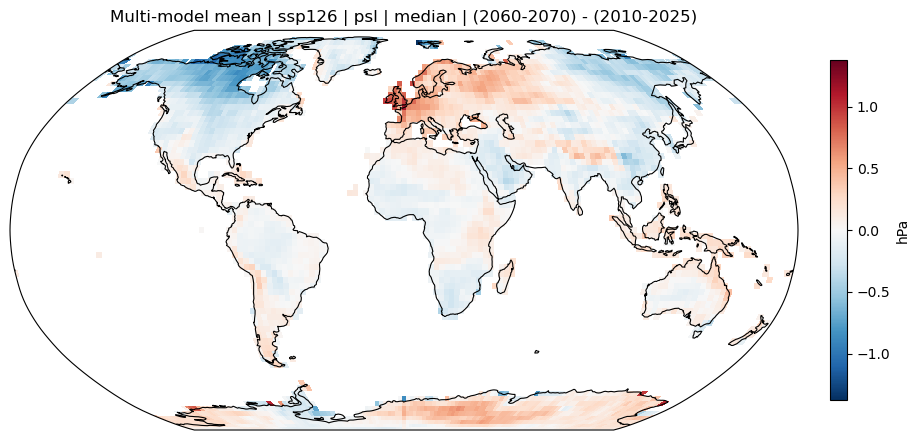

/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/179849665.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=1) # axis=1 refers to the time dimension, np.namean ignores the missing values
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/177438377.py:67: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


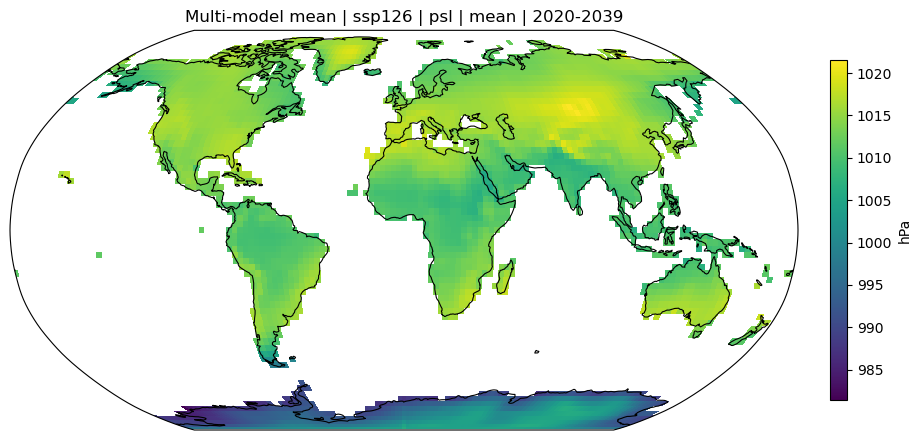

In [11]:
script1_global_map(
        varname="psl",
        scenario="ssp126",
        period1=(2010, 2025),
        period2=(2060, 2070),
        stat="median",
        multimodel=True,
        model_name=None
    )

script1_global_map(
         varname="psl",
         scenario="ssp126",
         period1=(2020, 2039),
         #period2=None,
         stat="mean",
         multimodel=True,
         model_name=None
     )


/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/179849665.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=1) # axis=1 refers to the time dimension, np.namean ignores the missing values
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_75282/177438377.py:67: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


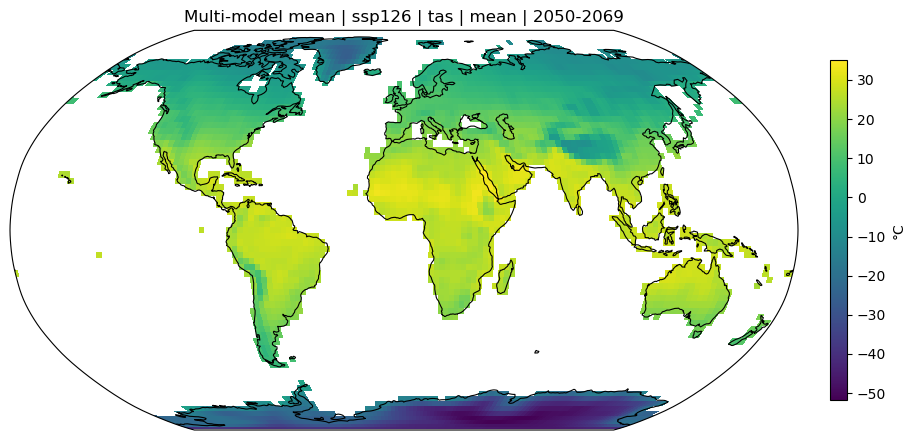

ValueError: Conflicting options: you set multimodel=True but also provided model_name. Either set multimodel=False (single-model plot) or set model_name=None (multi-model mean).

In [12]:
script1_global_map(
         varname="tas",
         scenario="ssp126",
         period1=(2050, 2069),
         #period2=None,
         stat="mean",
         multimodel=True,
         model_name=None
     )

script1_global_map(
         varname="tas",
         scenario="ssp119",
         period1=(2050, 2069),
         #period2=None,
         stat="mean",
         multimodel=True,
         model_name="CNRM_ESM2-1"
     )

/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/179849665.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=1) # axis=1 refers to the time dimension, np.namean ignores the missing values
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/2813360624.py:62: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


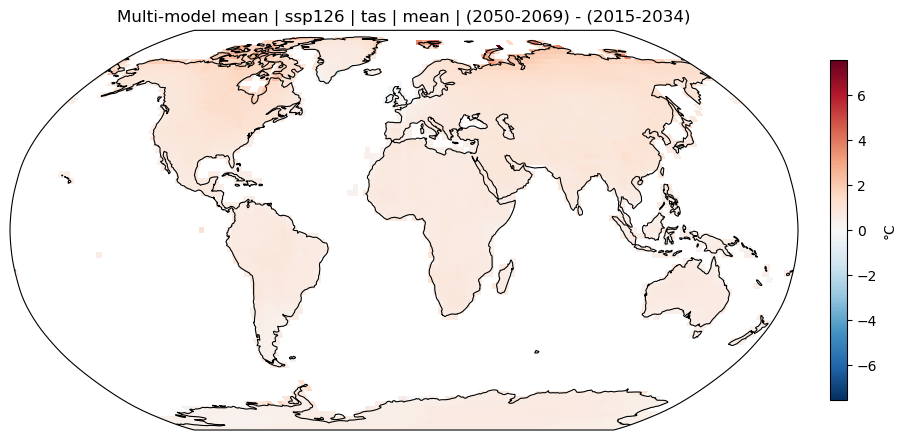

/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/179849665.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=1) # axis=1 refers to the time dimension, np.namean ignores the missing values
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/2813360624.py:62: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


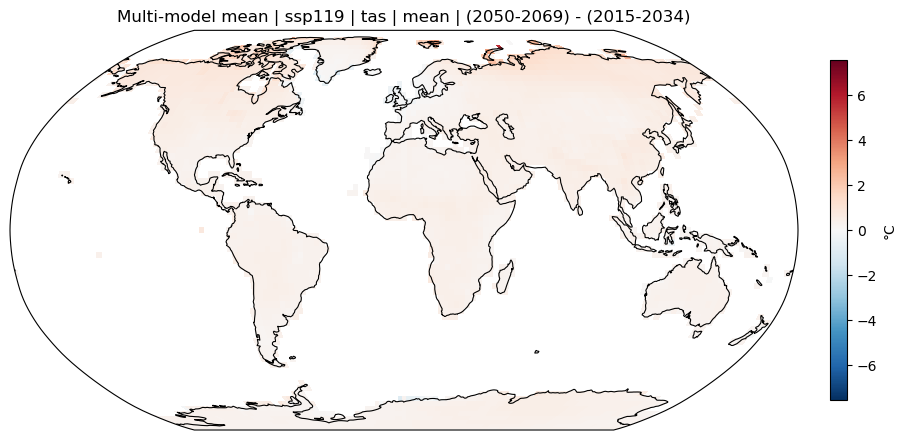

In [ ]:
script1_global_map(
         varname="tas",
         scenario="ssp126",
         period1=(2015, 2034),
         period2=(2050, 2069),
         stat="mean",
         multimodel=True,
         model_name=None
     )

script1_global_map(
         varname="tas",
         scenario="ssp119",
         period1=(2015, 2034),
         period2=(2050,2069),
         stat="mean",
         multimodel=True,
         model_name=None
     )

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/2813360624.py:62: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


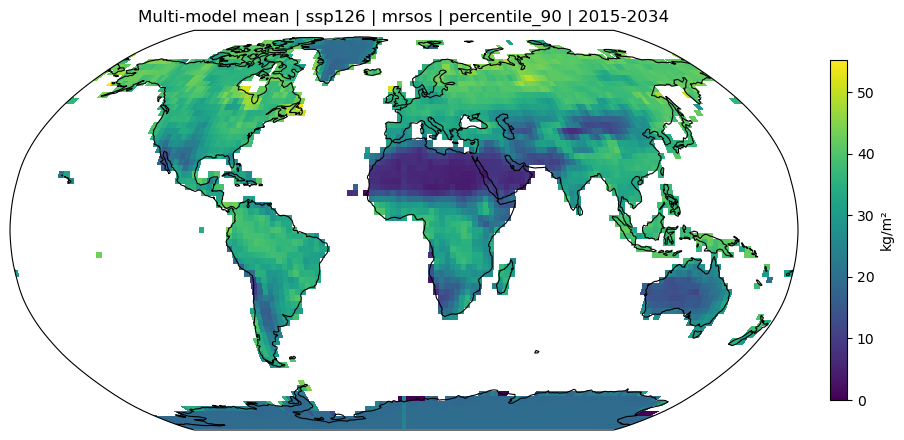

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/3739342933.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_74304/2813360624.py:62: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


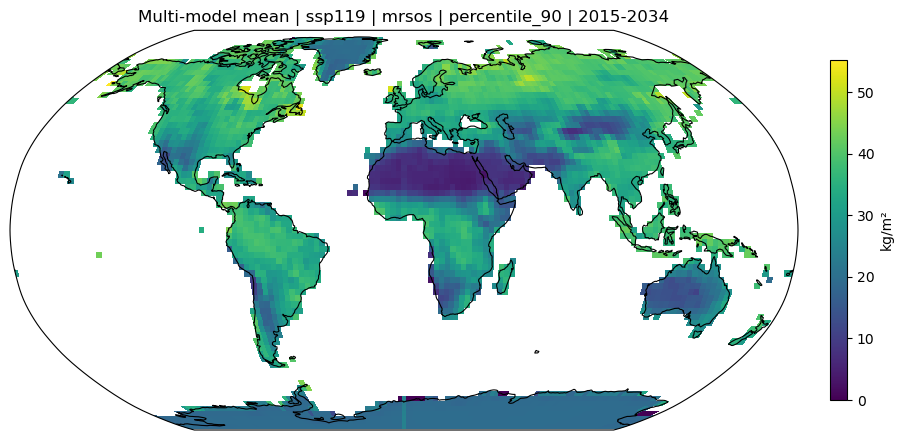

In [ ]:
script1_global_map(varname="mrsos", scenario="ssp126", period1=(2015,2034), stat="percentile_90", multimodel=True,
         model_name=None)
script1_global_map(varname="mrsos", scenario="ssp119", period1=(2015,2034), stat="percentile_90", multimodel=True,
         model_name=None)
